# Detecting Covid-19 with Keras neural network

Per lanciare questo notebook lanciare Jupyter con il comando:

jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000000

## 0. Import and loading

In [1]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array

Using TensorFlow backend.


In [2]:
covid_path = r'D:\MasterBigData\Didattica\DL\Progetto\576013_1042828_bundle_archive\COVID-19 Radiography Database\images\Covid-19'
normal_path = r'D:\MasterBigData\Didattica\DL\Progetto\576013_1042828_bundle_archive\COVID-19 Radiography Database\images\Normal'
viral_path = r'D:\MasterBigData\Didattica\DL\Progetto\576013_1042828_bundle_archive\COVID-19 Radiography Database\images\Viral'
paths = [covid_path, normal_path, viral_path]

In [3]:
%%time
X=[]
y=[]
for i in range(len(paths)):
    images = [f for f in os.listdir(paths[i])]
    for image in images:
        img = load_img(paths[i]+'\\\\'+image, target_size=(250, 250))
        img = img_to_array(img)
        X.append(img)
        y.append(i)
print(X)
print(y)

[array([[[ 46.,  44.,  45.],
        [ 54.,  53.,  54.],
        [ 60.,  58.,  59.],
        ...,
        [ 91.,  90.,  91.],
        [ 70.,  71.,  71.],
        [ 55.,  53.,  56.]],

       [[ 53.,  51.,  52.],
        [ 53.,  51.,  53.],
        [ 58.,  56.,  56.],
        ...,
        [ 70.,  70.,  72.],
        [ 78.,  77.,  80.],
        [ 67.,  67.,  69.]],

       [[ 52.,  50.,  53.],
        [ 54.,  54.,  55.],
        [ 58.,  58.,  59.],
        ...,
        [ 81.,  81.,  83.],
        [ 64.,  64.,  66.],
        [ 58.,  56.,  59.]],

       ...,

       [[ 72.,  71.,  73.],
        [ 80.,  80.,  82.],
        [ 65.,  65.,  67.],
        ...,
        [ 73.,  73.,  75.],
        [100., 101., 103.],
        [ 89.,  89.,  91.]],

       [[ 81.,  81.,  83.],
        [ 69.,  69.,  71.],
        [ 67.,  67.,  69.],
        ...,
        [ 80.,  80.,  82.],
        [ 86.,  86.,  88.],
        [ 94.,  93.,  95.]],

       [[ 77.,  78.,  78.],
        [ 64.,  65.,  67.],
        [ 66., 

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [5]:
#abbiamo verificato che lo split mantiene inalterate le proporzioni
import pandas as pd

print('all:')
print(pd.Series(y).value_counts(normalize=True))
print()
print('train:')
print(pd.Series(y_train).value_counts(normalize=True))
print()
print('test:')
print(pd.Series(y_test).value_counts(normalize=True))

all:
2    0.465237
1    0.463853
0    0.070910
dtype: float64

train:
2    0.465398
1    0.463668
0    0.070934
dtype: float64

test:
2    0.464594
1    0.464594
0    0.070812
dtype: float64


In [6]:
#target in forma vettoriale
from keras.utils.np_utils import to_categorical
y_train_labels = to_categorical(y_train)
y_test_labels = to_categorical(y_test)

In [7]:
X_train, X_test = np.array(X_train), np.array(X_test)
#y_train_labels, y_test_labels =  np.array(y_train_labels), np.array(y_test_labels)

## 1. Our models

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Convolution2D
from keras.optimizers import RMSprop

In [9]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', 
                                                  np.unique(y_train),
                                                  y_train)

for _class in np.unique(y_train):
    print(f"Weight of instances in class {_class:d}: {class_weights[_class]:.2f}")

Weight of instances in class 0: 4.70
Weight of instances in class 1: 0.72
Weight of instances in class 2: 0.72


In [10]:
seed = 7
np.random.seed(seed)

In [11]:
#target in forma vettoriale
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=seed)
loss_train_list = []
loss_val_list = []
acc_train_list = []
acc_val_list = []
cvscores = []
for train, val in kfold.split(X_train, y_train):
    #set the network
    model = Sequential()
    model.add( Conv2D(32, (3, 3), input_shape=(250, 250, 3))) 
    model.add( Activation("relu") )
    model.add( MaxPooling2D((2, 2)) )
    model.add( Conv2D(64, (3, 3))) 
    model.add( Activation("relu") )
    model.add( MaxPooling2D((2, 2)) )
    model.add( Conv2D(128, (3, 3))) 
    model.add( Activation("relu") )
    model.add( MaxPooling2D((2, 2)) )
    model.add( Conv2D(256, (3, 3))) 
    model.add( Activation("relu") )
    model.add( MaxPooling2D((2, 2)) )
    model.add( Flatten() )
    model.add( Dense(128) )
    model.add( Activation("relu") )
    model.add(Dense(3, activation='softmax'))
    #compile
    model.compile( optimizer="rmsprop",
                   loss='categorical_crossentropy',
                   metrics=['accuracy'] )
    #fit
    hist = model.fit(X_train[train], to_categorical(np.array(y_train)[train]), 
                 class_weight=class_weights,
                 batch_size=32, epochs=2,
                 validation_data = (X_train[val], to_categorical(np.array(y_train)[val]))
                    )
    # evaluate the model
    scores = model.evaluate(X_train[val], to_categorical(np.array(y_train)[val]), verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    loss_train_list.append(hist.history['loss'])
    loss_val_list.append(hist.history['val_loss'])
    acc_train_list.append(hist.history['accuracy'])
    acc_val_list.append(hist.history['val_accuracy']) 
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Train on 1734 samples, validate on 578 samples
Epoch 1/2
1734/1734 [==============================] - 120s 69ms/step - loss: 297.5923 - accuracy: 0.4302 - val_loss: 1.0951 - val_accuracy: 0.4637
Epoch 2/2
1734/1734 [==============================] - 116s 67ms/step - loss: 28.0033 - accuracy: 0.4573 - val_loss: 1.0869 - val_accuracy: 0.4654
accuracy: 46.54%
Train on 1734 samples, validate on 578 samples
Epoch 1/2
1734/1734 [==============================] - 121s 70ms/step - loss: 37.9517 - accuracy: 0.5980 - val_loss: 1.3843 - val_accuracy: 0.4100
Epoch 2/2
1734/1734 [==============================] - 120s 69ms/step - loss: 2.3725 - accuracy: 0.7053 - val_loss: 2.4368 - val_accuracy: 0.3322
accuracy: 33.22%
Train on 1734 samples, validate on 578 samples
Epoch 1/2
1734/1734 [==============================] - 120s 69ms/step - loss: 131.5759 - accuracy: 0.5779 - val_loss: 0.6656 - val_accuracy: 0.7699
Epoch 2/2
1734/1734 [==============================] - 119s 68ms/step - loss: 2.5689 - ac

In [12]:
model.save(r'D:\MasterBigData\Didattica\DL\Progetto\Detecting-COVID\model_kfold')

In [28]:
# We process the results for plotting:
# train loss
dizio = {}
for i in range(len(loss_train_list)):
    for k in range(len(loss_train_list[i])):
        if k in dizio:
            dizio[k].append(loss_train_list[i][k])
        else:
            dizio[k] = [loss_train_list[i][k]]
medie = []
for key, value in dizio.items():
    medie.append(np.mean(value))
print('train:')
print('epoch means:',medie)   
deviazioni = []
for key, value in dizio.items():
    deviazioni.append(np.std(value))
print('epoch means stds:',deviazioni)
print()

#validation loss
dizio = {}
for i in range(len(loss_val_list)):
    for k in range(len(loss_val_list[i])):
        if k in dizio:
            dizio[k].append(loss_val_list[i][k])
        else:
            dizio[k] = [loss_val_list[i][k]]
medie_val = []
for key, value in dizio.items():
    medie_val.append(np.mean(value))
print('validation:')
print('epoch means:',medie_val)   
deviazioni_val = []
for key, value in dizio.items():
    deviazioni_val.append(np.std(value))
print('epoch stds:',deviazioni_val)

train:
epoch means: [128.77506630646008, 9.08321562250206]
epoch means stds: [104.02379813576592, 10.930130157113869]

validation:
epoch means: [0.9905539209145575, 1.3121455204012484]
epoch stds: [0.2745805903631863, 0.6736457831908879]


In [29]:
# We process the results for plotting:
# train accuracy
dizio = {}
for i in range(len(acc_train_list)):
    for k in range(len(acc_train_list[i])):
        if k in dizio:
            dizio[k].append(acc_train_list[i][k])
        else:
            dizio[k] = [acc_train_list[i][k]]
acc_medie = []
for key, value in dizio.items():
    acc_medie.append(np.mean(value))
print('train:')
print('epoch means:',acc_medie)   
acc_deviazioni = []
for key, value in dizio.items():
    acc_deviazioni.append(np.std(value))
print('epoch means stds:',acc_deviazioni)
print()

#validation loss
dizio = {}
for i in range(len(acc_val_list)):
    for k in range(len(acc_val_list[i])):
        if k in dizio:
            dizio[k].append(acc_val_list[i][k])
        else:
            dizio[k] = [acc_val_list[i][k]]
acc_medie_val = []
for key, value in dizio.items():
    acc_medie_val.append(np.mean(value))
print('validation:')
print('epoch means:',acc_medie_val)   
acc_deviazioni_val = []
for key, value in dizio.items():
    acc_deviazioni_val.append(np.std(value))
print('epoch stds:',acc_deviazioni_val)

NameError: name 'acc_train_list' is not defined

In [17]:
i = 0
for mu,sigma in zip(medie,deviazioni):
    i+=1
    print("Epoch %i: %.2f (+/- %.2f)" % (i, mu, sigma))
    

Epoch 1: 128.78 (+/- 104.02)
Epoch 2: 9.08 (+/- 10.93)


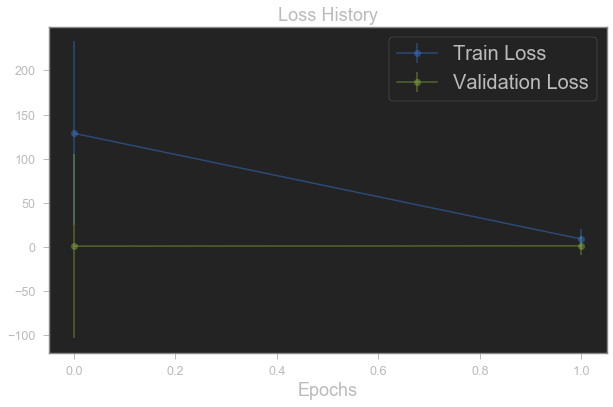

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
# plot training epochs

fig, axes = plt.subplots(figsize=(10,6))

axes.errorbar(list(range(len(medie))), medie, yerr=deviazioni, fmt='-o', label='Train Loss', alpha = 0.5)
#axes.plot(hist.history['acc'], label='Train Accuracy')

#axes.plot(medie_val, label='Valid Loss')
axes.errorbar(list(range(len(medie_val))), medie_val, yerr=deviazioni, fmt='-o', label='Validation Loss', alpha=0.5)

axes.set_title("Loss History", fontsize=18)
axes.set_xlabel("Epochs", fontsize=18)
axes.legend(fontsize=20)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
# plot training epochs

fig, axes = plt.subplots(figsize=(10,6))

axes.plot(acc_medie, label='Train Loss')
#axes.plot(hist.history['acc'], label='Train Accuracy')

axes.plot(acc_medie_val, label='Valid Loss')
#axes.plot(hist.history['val_acc'], label='Valid Accuracy')

axes.set_title("Loss History", fontsize=18)
axes.set_xlabel("Epochs", fontsize=18)
axes.legend(fontsize=20)

In [30]:
model.summary(line_length=None, positions=None, print_fn=None)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 248, 248, 32)      896       
_________________________________________________________________
activation_16 (Activation)   (None, 248, 248, 32)      0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 122, 122, 64)      18496     
_________________________________________________________________
activation_17 (Activation)   (None, 122, 122, 64)      0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 59, 59, 128)      

## 3. Evaluation

Accuracy: 0.9814014


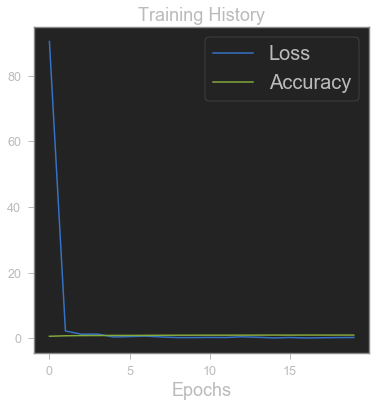

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
# plot training epochs

fig, axes = plt.subplots(figsize=(6,6))

axes.plot(hist.history['loss'], label='Loss')
axes.plot(hist.history['accuracy'], label='Accuracy')

axes.set_title("Training History", fontsize=18)
axes.set_xlabel("Epochs", fontsize=18)
axes.legend(fontsize=20)

# Final accuracy
print ("Accuracy:", hist.history['accuracy'][-1])

In [62]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# convert form prediction to id
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1) # argmax along axis 1

y_true = y_test

# compute confusion matrix
print ("Confusion Matrix")
print ( confusion_matrix(y_true, y_pred) )
print()

# compute classification report
print ("Classification Report")
print ( classification_report(y_true, y_pred) )

Confusion Matrix
[[ 36   2   3]
 [  0 259  10]
 [  3  13 253]]

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.88      0.90        41
           1       0.95      0.96      0.95       269
           2       0.95      0.94      0.95       269

    accuracy                           0.95       579
   macro avg       0.94      0.93      0.93       579
weighted avg       0.95      0.95      0.95       579



In [65]:
#comando per salvare il modello
model.save(r'D:\MasterBigData\Didattica\DL\Progetto\Detecting-COVID\model_1')

# Augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
                                ##augmentation parameters:
                                  # ,shear_range=0.2, 
                                  # zoom_range=0.2, 
                                  # horizontal_flip=True)
                                  
train_images = train_datagen.flow_from_directory(train_path,
                     target_size=(256, 256),
                     batch_size=32,
                     color_mode="rgb",
                     class_mode="categorical"
                     #shuffle=True,
                     #seed=42
                            )

In [ ]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=False)
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(x_train)
# fits the model on batches with real-time data augmentation:
model.fit(datagen.flow(x_train, y_train, batch_size=32),
          steps_per_epoch=len(x_train) / 32, epochs=epochs)